In [3]:
#Import the necessary packages
import graphviz
import pandas as pd
import sklearn.tree
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from numpy import nan
from numpy import round
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from io import StringIO
#from StringIO import StringIO

In [9]:
#Importing dataset 

#Defining the function
def get_lending_club_data():
    raw_data = pd.read_csv("LendingClub2012to2013.csv", low_memory = False, skiprows=[0])
    return(raw_data)

#Calling the import function
lc = get_lending_club_data()

In [19]:
lc['earliest_cr_line']

0         Jun-98
1         Mar-94
2         Dec-09
3         Oct-98
4         Jan-89
5         Mar-99
6         Nov-94
7         Nov-97
8         Oct-89
9         May-91
10        Oct-86
11        Jun-88
12        Aug-95
13        Mar-98
14        Jun-89
15        Jun-01
16        Jan-07
17        Oct-10
18        Jul-91
19        Jul-92
20        Sep-03
21        Jun-93
22        Nov-78
23        Feb-85
24        Mar-82
25        Jul-01
26        Dec-98
27        Sep-00
28        Dec-93
29        Dec-01
           ...  
188153    Dec-97
188154    Dec-88
188155    Nov-87
188156    Oct-71
188157    Jul-99
188158    Dec-94
188159    Feb-99
188160    Sep-04
188161    Jun-95
188162    Sep-65
188163    Apr-01
188164    Jul-88
188165    Sep-05
188166    Dec-04
188167    May-95
188168    Jul-98
188169    Feb-97
188170    Jan-02
188171    Jul-95
188172    Feb-88
188173    Aug-04
188174    Jan-94
188175    Apr-01
188176    Oct-88
188177    Jan-04
188178    Sep-00
188179    Aug-01
188180    Feb-

In [20]:
def data_clean(raw_data):
    #Selecting only those rows which have loan_status values as "Fully Paid" or "Charged off" or "Default"
    no_incomplete_rows = raw_data[raw_data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
    # Setting the values as Fully Paid = 0 and Changed off or Default = 1
    no_incomplete_rows['loan_status'] = no_incomplete_rows['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1)
    # Removing the Target Leakage
    leakage_to_drop = ['issue_d', 'recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'pymnt_plan', 'next_pymnt_d']
    # Removing the Variables which have no significance
    no_significant_information_features_to_drop = ['mths_since_recent_revol_delinq','mths_since_recent_bc_dlq','mths_since_last_major_derog','mths_since_last_record','member_id','all_util', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il',
                                                   'verification_status_joint', 'annual_inc_joint', 'application_type',  'policy_code', 'total_cu_tl','mths_since_last_delinq','num_il_tl','emp_length','tot_coll_amt','num_accts_ever_120_pd','num_bc_tl', 'num_bc_tl','num_op_rev_tl','num_rev_accts',
                                                   'num_sats','num_tl_90g_dpd_24m','pct_tl_nvr_dlq','tax_liens','total_il_high_credit_limit',
                                                   'funded_amnt', 'grade', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc','initial_list_status',
                                                   'collections_12_mths_ex_med','acc_now_delinq','delinq_amnt', 'num_bc_sats', 'pub_rec_bankruptcies']
    # Removing the text features
    text_columns = ['emp_title', 'url', 'desc', 'title', 'zip_code', 'id','addr_state']

    # Selecting the final Varibales
    no_leakage = no_incomplete_rows.drop(text_columns + leakage_to_drop + no_significant_information_features_to_drop, axis = 1)
    #Filtering and Formatting the variables
    no_leakage['earliest_cr_line'] = pd.to_datetime(no_leakage['earliest_cr_line'], format='%b-%y')
    no_leakage['time_since_earliest_cr_line'] = no_leakage['earliest_cr_line'].apply(lambda x: pd.to_datetime('20000101', format='%Y%m%d') - x).dt.days
    no_leakage['int_rate'] = pd.to_numeric(no_leakage['int_rate'].str.strip('%'), errors='coerce')
    no_leakage['revol_util'] = pd.to_numeric(no_leakage['revol_util'].str.strip('%'), errors='coerce')
    no_leakage['term'] = no_leakage['term'].apply(lambda x: x.strip().replace(" ", "_"))
    no_leakage = no_leakage.drop(['earliest_cr_line'], axis = 1)
    return(no_leakage)

def data_pre_process(no_leakage):
    categorical = no_leakage.select_dtypes(include=['object'])
    numeric = no_leakage.select_dtypes(exclude=['object'])
    
    # create dummy variables
    for name, values in categorical.items():
        dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
        cleaned_data = pd.concat([numeric, dummies], axis=1)
    return(cleaned_data)

def data_Imputation(cleaned_data):
    for name in cleaned_data:
        if pd.isnull(cleaned_data[name]).sum() > 0:
            cleaned_data["%s_mi" % (name)] = pd.isnull(cleaned_data[name])
            median = cleaned_data[name].median()
            cleaned_data[name] = cleaned_data[name].apply(lambda x: median if pd.isnull(x) else x)
    return(cleaned_data)

In [21]:
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn import preprocessing

import numpy as np
from sklearn.model_selection import train_test_split

# Import the raw data from the csv file
raw_data = get_lending_club_data()

# Clean and process the data 
no_leakage = data_clean(raw_data)

# Pre-process the data for modelling
cleaned_data  = data_pre_process(no_leakage)

# Imputation of missing values
clean_imputed_data = data_Imputation(cleaned_data)

#Defining Target and independent/predictor variables
y = clean_imputed_data['loan_status']
X = clean_imputed_data.drop(['loan_status'], axis = 1)

#Creating the holdout
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

loan_status
Charged Off            27536
Current                15430
Default                   28
Fully Paid            143919
In Grace Period          387
Late (16-30 days)        175
Late (31-120 days)       706
Name: loan_status, dtype: int64


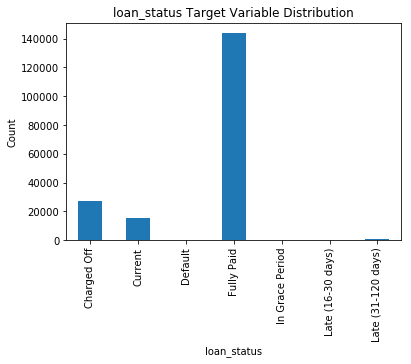

In [3]:
#Importing the python matplot library for exploratory data analysis
import matplotlib.pyplot as plt
import pandas as pd

# Exploratory Analysis for loan_status variable
var = raw_data.groupby('loan_status').loan_status.count()  
print(var)
plt.title('loan_status Target Variable Distribution')
plt.xlabel('loan_status')
plt.ylabel('Count')
var.plot(kind='bar')
plt.show()

loan_status
0    143919
1     27564
Name: loan_status, dtype: int64


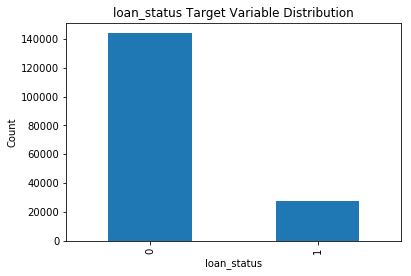

In [4]:
var = clean_imputed_data.groupby('loan_status').loan_status.count()  
print(var)
# Exploratory Analysis for loan_status variable after cleaning
plt.title('loan_status Target Variable Distribution')
plt.xlabel('loan_status')
plt.ylabel('Count')
var.plot(kind='bar')
plt.show()

purpose
car                     1951
credit_card            43170
debt_consolidation    111451
home_improvement       10297
house                   1093
major_purchase          3659
medical                 1519
moving                  1038
other                   8896
renewable_energy         122
small_business          2745
vacation                 909
wedding                 1331
Name: loan_status, dtype: int64


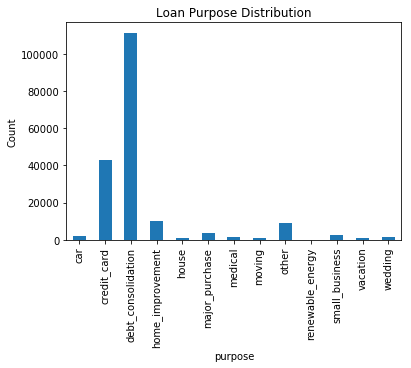

In [5]:
var = raw_data.groupby('purpose').loan_status.count() 
print(var)
# Exploratory Analysis for loan_status Loan purpose
plt.title('Loan Purpose Distribution')
plt.xlabel('Purpose')
plt.ylabel('Count')
var.plot(kind='bar')
plt.show()

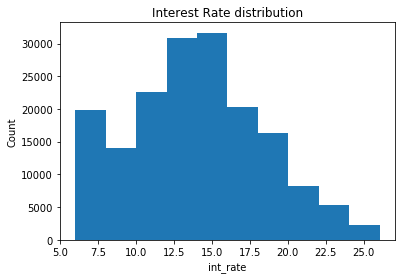

In [13]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
# Exploratory Analysis for interest rate variable
ax.hist(no_leakage['int_rate'],bins = 10)
plt.title('Interest Rate distribution')
plt.xlabel('int_rate')
plt.ylabel('Count')
plt.show()

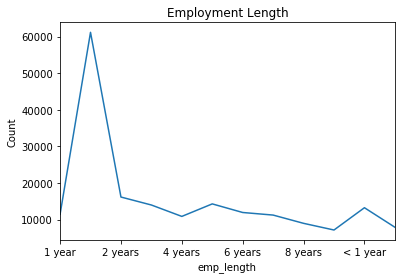

In [21]:
var = raw_data.groupby('emp_length').loan_status.count() 
# Exploratory Analysis for Employment length variable
plt.title('Employment Length')
plt.xlabel('emp_length')
plt.ylabel('Count')
var.plot(kind='line')
plt.show()


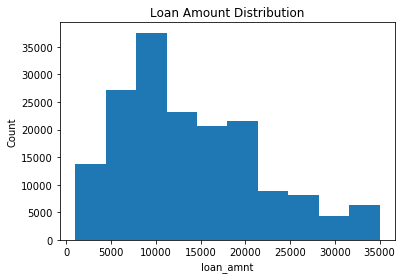

In [23]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
# Exploratory Analysis for loan amount Distribution
ax.hist(no_leakage['loan_amnt'],bins = 10)
plt.title('Loan Amount Distribution')
plt.xlabel('loan_amnt')
plt.ylabel('Count')
plt.show()

In [20]:
# Exploring the features min, max, count etc values by gouping by loan_status variable
explore_features = raw_data.drop(['id'], axis = 1)
test = explore_features.groupby('loan_status')
test.describe()

acc_now_delinq  acc_open_past_24mths  all_util  \
loan_status                                                                
Charged Off        count    27536.000000          26327.000000       0.0   
                   mean         0.003305              4.466403       NaN   
                   std          0.068896              2.843576       NaN   
                   min          0.000000              0.000000       NaN   
                   25%          0.000000              2.000000       NaN   
                   50%          0.000000              4.000000       NaN   
                   75%          0.000000              6.000000       NaN   
                   max          5.000000             33.000000       NaN   
Current            count    15430.000000          15168.000000       0.0   
                   mean         0.004601              3.635351       NaN   
                   std          0.069569              2.500875       NaN   
                   min          0.000000              0.000000       NaN   
                   25%          0.000000              2.000000       NaN   
                   50%          0.000000              3.000000       NaN   
                   75%          0.000000              5.000000       NaN   
                   max          2.000000             20.000000       NaN   
Default            count       28.000000             28.000000       0.0   
                   mean         0.000000              4.714286       NaN   
                   std          0.000000              3.441115       NaN   
                   min          0.000000              1.000000       NaN   
                   25%          0.000000              2.000000       NaN   
                   50%          0.000000              3.500000       NaN   
                   75%          0.000000              6.500000       NaN   
                   max          0.000000             13.000000       NaN   
Fully Paid         count   143919.000000         137917.000000       0.0   
                   mean         0.002404              3.856450       NaN   
                   std          0.054862              2.620602       NaN   
                   min          0.000000              0.000000       NaN   
                   25%          0.000000              2.000000       NaN   
                   50%          0.000000              3.000000       NaN   
                   75%          0.000000              5.000000       NaN   
                   max          5.000000             40.000000       NaN   
In Grace Period    count      387.000000            376.000000       0.0   
                   mean         0.002584              4.284574       NaN   
                   std          0.050833              2.953213       NaN   
                   min          0.000000              0.000000       NaN   
                   25%          0.000000              2.000000       NaN   
                   50%          0.000000              4.000000       NaN   
                   75%          0.000000              6.000000       NaN   
                   max          1.000000             17.000000       NaN   
Late (16-30 days)  count      175.000000            172.000000       0.0   
                   mean         0.000000              4.331395       NaN   
                   std          0.000000              3.540997       NaN   
                   min          0.000000              0.000000       NaN   
                   25%          0.000000              2.000000       NaN   
                   50%          0.000000              4.000000       NaN   
                   75%          0.000000              5.250000       NaN   
                   max          0.000000             27.000000       NaN   
Late (31-120 days) count      706.000000            698.000000       0.0   
                   mean         0.002833              4.190544       NaN   
                   std          0.053187              2.734984       NaN  

In [11]:
-

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Identifying the variables with missing values
raw_data.isnull().sum()

id                                     0
member_id                              2
loan_amnt                              2
funded_amnt                            2
funded_amnt_inv                        2
term                                   2
int_rate                               2
installment                            2
grade                                  2
sub_grade                              2
emp_title                          11736
emp_length                             2
home_ownership                         2
annual_inc                             2
verification_status                    2
issue_d                                2
loan_status                            2
pymnt_plan                             2
url                                    2
desc                              106705
purpose                                2
title                                  9
zip_code                               2
addr_state                             2
dti             

In [12]:
# Final Variables selection
no_leakage.isnull().sum()

loan_amnt                          0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
sub_grade                          0
home_ownership                     0
annual_inc                         0
verification_status                0
loan_status                        0
purpose                            0
dti                                0
fico_range_low                     0
fico_range_high                    0
inq_last_6mths                     0
revol_util                       117
tot_cur_bal                    26658
total_rev_hi_lim               26658
acc_open_past_24mths            7211
avg_cur_bal                    26664
bc_open_to_buy                  8646
bc_util                         8726
chargeoff_within_12_mths           0
mo_sin_old_il_acct             32430
mo_sin_old_rev_tl_op           26659
mo_sin_rcnt_rev_tl_op          26659
mo_sin_rcnt_tl                 26658
m

In [12]:
                             ############### Naive bayes Gaussian Classifier #####################
from sklearn.naive_bayes import GaussianNB
nbg = GaussianNB()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', nbg) ])

# Parameters for tuning the model
from sklearn.model_selection import GridSearchCV
optimized_nbg = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict()
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1)

#Fitting the model with Grid Search
optimized_nbg.fit(X_train, y_train)

#Get the best estimator from the grid Search
print(" The optimized_nbg.best_score is : ", optimized_nbg.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


 The optimized_nbg.best_score is :  0.635767452508


In [15]:
              ############### Support Vector Machines Linear Classifier #####################
from sklearn.svm import LinearSVC
clf = LinearSVC()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', clf) ])


# Parameters for tuning the model
class_weight = ['balanced']
loss = [ 'hinge', 'squared_hinge']
max_iter = [1000,1250,1400]
from sklearn.model_selection import GridSearchCV
optimized_clf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict
                              (model__class_weight = class_weight,
                               model__loss = loss,
                               model__max_iter = max_iter)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1)

#Fitting the model with Grid Search
optimized_clf.fit(X_train, y_train)

#Get the best estimator from the grid Search
print("testing",optimized_clf.best_estimator_)
print(" The optimized_clf.best_score is : ", optimized_clf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.3min finished


testing Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
 The optimized_clf.best_score is :  0.710143909224


In [16]:
                                 ######## Evaluating the results on holdout ########
from sklearn.metrics import roc_auc_score
y_pred = optimized_clf.predict(X_test)

roc_on_holdout = roc_auc_score(y_test, y_pred)

print("The AUC the final model choosen is ", roc_on_holdout)

The AUC the final model choosen is  0.644365100176


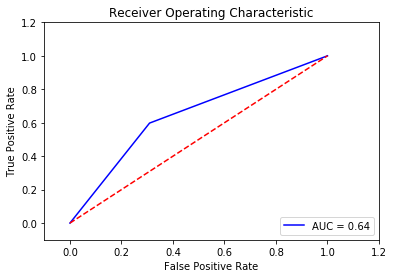

In [17]:
              #################               Plotting the ROC Curve               ############### 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()